I'm not going to annotate this notebook as heavily, because I don't intend to post it, but before we can do our EDA, we need our data in the follow format.

Name | Alias | Papers | StartYear | Stirling Diversity Index | H-index

In [152]:
import os
import metaknowledge as mk
import networkx as nx
import pandas as pd
import csv
import math
import numpy as np

#import files to let us calculate Rao-Stirling diversity
Cosciting = pd.read_csv('CosCiting.csv', sep=',', header=0, index_col=0)
JournalCats = pd.read_excel('WoS History Nov 2017.xlsx', header=0)
JournalCats.set_index('20 Char', inplace=True)

os.chdir('RCs')

#load up a record collection
RC = mk.RecordCollection("BRECORD.txt")

os.chdir('..')

#check that we've loaded it up
print(RC.glimpse())

RecordCollection glimpse made at: 2018-07-23 21:03:22
1692 Records from BRECORD

Top Authors
1 Kaner, Richard B. B.
2 Daugherty, Alan
3 Zink, Jeffrey I.
4 Cassis, Lisa A.
5 Kim, Chang-Jin
6 Wiggers, Hartnnut
7 Schulz, Christof
8 Lu, Hong
9 Howatt, Deborah A.

Top Journals
1 ABSTRACTS OF PAPERS OF THE AMERICAN CHEMICAL SOCIETY
2 ARTERIOSCLEROSIS THROMBOSIS AND VASCULAR BIOLOGY
3 JOURNAL OF THE AMERICAN CHEMICAL SOCIETY
4 ACS NANO
5 JOURNAL OF NEUROTRAUMA
6 JOURNAL OF MICROELECTROMECHANICAL SYSTEMS
7 JOURNAL OF APPLIED PHYSICS
8 SMALL
8 JOURNAL OF PHYSICAL CHEMISTRY C

Top Cited
1 Daugherty A, 2000, J CLIN INVEST, V105, P1605, DOI 10.1172/JCI7818
2 Liong M, 2008, ACS NANO, V2, P889, DOI 10.1021/nn800072t
3 Lu J, 2007, SMALL, V3, P1341, DOI 10.1002/smll.200700005
3 Saraff K, 2003, ARTERIOSCL THROM VAS, V23, P1621, DOI 10.1161/01.ATV.000008563
4 KRESGE CT, 1992, NATURE, V359, P710, DOI 10.1038/359710a0
5 Daugherty A, 1999, ANN NY ACAD SCI, V892, P108, DOI 10.1111/j.1749-6632.1999.t
6 Lu J,

In [153]:
print(RC.glimpse())

RecordCollection glimpse made at: 2018-07-23 21:03:23
1692 Records from BRECORD

Top Authors
1 Kaner, Richard B. B.
2 Daugherty, Alan
3 Zink, Jeffrey I.
4 Cassis, Lisa A.
5 Kim, Chang-Jin
6 Wiggers, Hartnnut
7 Schulz, Christof
8 Lu, Hong
9 Howatt, Deborah A.

Top Journals
1 ABSTRACTS OF PAPERS OF THE AMERICAN CHEMICAL SOCIETY
2 ARTERIOSCLEROSIS THROMBOSIS AND VASCULAR BIOLOGY
3 JOURNAL OF THE AMERICAN CHEMICAL SOCIETY
4 ACS NANO
5 JOURNAL OF NEUROTRAUMA
6 JOURNAL OF MICROELECTROMECHANICAL SYSTEMS
7 JOURNAL OF APPLIED PHYSICS
8 SMALL
8 JOURNAL OF PHYSICAL CHEMISTRY C

Top Cited
1 Daugherty A, 2000, J CLIN INVEST, V105, P1605, DOI 10.1172/JCI7818
2 Liong M, 2008, ACS NANO, V2, P889, DOI 10.1021/nn800072t
3 Lu J, 2007, SMALL, V3, P1341, DOI 10.1002/smll.200700005
3 Saraff K, 2003, ARTERIOSCL THROM VAS, V23, P1621, DOI 10.1161/01.ATV.000008563
4 KRESGE CT, 1992, NATURE, V359, P710, DOI 10.1038/359710a0
5 Daugherty A, 1999, ANN NY ACAD SCI, V892, P108, DOI 10.1111/j.1749-6632.1999.t
6 Lu J,

here the clever part is df.to_dict('index'), which turns our dataframe into a dict of dicts structure, which will have some advantages in a bit with passing lists to functions.  Pandas is great, but getting dataframes composed of mixed strings, ints, and lists to work can be a little frustrating.

In [154]:
df = pd.read_csv("Tags.csv", header=0)
df.set_index(['name'], inplace=True)
df.head()
scientists = df.to_dict('index')

for person in scientists:
    scientists[person]['h_tracker'] = []
    scientists[person]['titles'] = []

This loop runs through all the records in our record collect, and then check all the authors.  If one of the authors is one of the scientists we care about, it then:

* increments their papers by one
* adds the title to their collection so we can use it to calculate the Rao-Stirling score
* adds the number of times the paper has been cited to the h_tracker list
* and if the paper is older than their current listed start_year, set the start year to that date. 

In [155]:
for R in RC:
    for author in R['AF']:
        if author in scientists:
            scientists[author]['papers'] += 1
            scientists[author]['titles'].append(R['TI'])
            try:
                scientists[author]['h_tracker'].append(R['TC'])
            except:
                pass
            try:
                if R['PY'] < scientists[author]['start_year']:
                    scientists[author]['start_year'] = R['PY']
            except:
                pass

In [156]:
#our two functions from last time

#paperprep converts a record into the format
#{Title:{WCs:{AAA:1,BBB:2...},Cites:{CCC:1, DDD:2...}}}
#which calculates the Rao-Stirling index
#to access a part, use titles[Title]['WCs'] or titles[Title]['Cites'] and titles[Title]['Year'] for publication year

def PaperPrep(record, JournalCats):
    title = record['TI']
    try:
        line=record['WC']
    except:
        line='Unknown'
    dic = {}
    for item in line:
        if item.upper() in dic:
            dic[item.upper()] = dic[item.upper()] + 1
        else:
            dic[item.upper()] = 1
    WCs = dic

    citeslist =[]
    try:
        for cite in record['CR']:
            cite = str(cite)
            try:
                journal = cite.split(', ')[2]
            except:
                pass
            try:
                category = JournalCats.at[journal, 'WoS Category']
                if type(category) == str:
                    category = [category.upper()]
                if type(category) == np.ndarray:
                    catlist = []
                    for item in category:
                        catlist.append(item.upper())
                    category = catlist
            except:
                category = ['Unknown']
            citeslist = citeslist + category
    except:
        citeslist = ['Unknown']

    cites = {}
    for item in citeslist:
        if item in cites:
            cites[item]=cites[item]+1
        else:
            cites[item] = 1

    return({title:{'WCs':WCs,'Cites':cites}})

#RaoStirling takes a list of paper titles, and the prepped record collection.

def RaoStirling(samplelist, preppedRC):
    if type(samplelist)==str:
        samplelist = [samplelist]
    n = len(samplelist)
    qi = {}
    for title in samplelist:
        line = preppedRC[title]['WCs']
        dic = {}
        qi_N = 0.0
        for item in line:
            if item in dic:
                dic[item] = dic[item] +line[item]
            else:
                dic[item] = line[item]
            qi_N = qi_N +line[item]
        for WC in dic:
            if WC in qi:
                qi[WC] = qi[WC] + dic[WC] / qi_N * (1 / n)
            else:
                qi[WC] = dic[WC] / qi_N * (1 / n)
    qj = {}
    for title in samplelist:
        line = preppedRC[title]['Cites']
        dic = {}
        qj_N = 0.0
        for item in line:
            if item in dic:
                dic[item] = dic[item] + line[item]
            else:
                dic[item] = line[item]
            qj_N = qj_N + line[item]
        for WC in dic:
            if WC in qj:
                qj[WC]= qj[WC]+dic[WC]/qj_N*(1/n)
            else:
                qj[WC] = dic[WC]/qj_N*(1/n)
    SDI = 0
    for WCi in qi:
        for WCj in qj:
            try:
                invdistance = float(Cosciting.loc[WCi.upper(), WCj.upper()])
            except :
                invdistance = 1
            SDI = SDI + (1-invdistance)*qi[WCi]*qj[WCj]
    return(SDI)

In [157]:
titles = {}
for R in RC:
    titles.update(PaperPrep(R,JournalCats))

Calculating the h-index is something new for this project. The h-index was developed in 2005 by physicist Jorge E. Hirsch.  It's value is equal to N papers that have been cited N times.

So for example, the h-index of a person's who publications have been cited (7,6,3,1,1,0) is 3, from the papers that have been cited 7,6, and 3 times. 

This function takes a list, sorts it in descending order, and then moves through it, counting up by one, until it reaches the end of the list or finds a value less than the current count. That value is the h-index

In [138]:
def HIndex(h_list):
    h_list.sort(reverse=True)
    i = 0
    if h_list == []:
        return(i)
    while i < h_list[i]:
        i = i + 1
        if i == len(h_list):
            break
    return(i)

In [139]:
for author in scientists:
    scientists[author]['sdi'] = RaoStirling(scientists[author]['titles'],titles)
    scientists[author]['h_index'] =HIndex(scientists[author]['h_tracker'])

Now that we've calculated our key stats, it's to time convert back to a dataframe from our row-oriented dictionary

In [147]:
df2 = pd.DataFrame.from_dict(scientists, orient='index')
df2.head()

,university,group,rank,unit,interdisciplinary,alias,papers,start_year,sdi,h_index,h_tracker,titles
"Anderson, Bradley D.",Kentucky,Bioactive,Professor,College of Pharmacy,Interdisciplinary,A5,53,2006,0.402635,15,"[88, 83, 67, 39, 36, 31, 30, 27, 25, 25, 23, 1...",[What determines drug solubility in lipid vehi...
"Bayer, Peter",Duisberg-Essen,CRC1093,Full Professor,Faculty of Biology,Interdisciplinary,A12,57,1996,0.268110,20,"[307, 259, 103, 86, 60, 56, 52, 51, 34, 29, 29...",[Human PAPS Synthase Isoforms Are Dynamically ...
"Bhattacharyya, Dibakar",Kentucky,Bioactive,Professor and Director,Department of Chemical and Materials Engineering,Interdisciplinary,A3,43,2006,0.426674,14,"[98, 87, 60, 44, 44, 40, 32, 28, 23, 16, 15, 1...",[High Total Dissolved Solids Water Treatment b...
"Brockerhoff, Wolfgang",Duisberg-Essen,NaN,Dr.-Ing,Engineering,Non-Interdisciplinary,B16,3,1996,0.272793,3,"[33, 18, 3]",[InAlAs/InGaAs/InP HFET with suppressed impact...
"Carman, Greg P.",UCLA,NaN,Distinguished Professor,Mechanical and Aerospace Engineering,Non-Interdisciplinary,B2,19,2006,0.473499,8,"[31, 27, 19, 14, 13, 13, 12, 8, 7, 7, 2, 2, 1,...",[Thin-film nitinol (NiTi): A feasibility study...


In [148]:
df2=df2[['alias', 'interdisciplinary','papers','start_year','sdi','h_index']]
df2.set_index(['alias'], inplace=True)
df2.head()


,interdisciplinary,papers,start_year,sdi,h_index
alias,,,,,
A5,Interdisciplinary,53,2006,0.402635,15
A12,Interdisciplinary,57,1996,0.268110,20
A3,Interdisciplinary,43,2006,0.426674,14
B16,Non-Interdisciplinary,3,1996,0.272793,3
B2,Non-Interdisciplinary,19,2006,0.473499,8


In [151]:
df2.sort_index(inplace=True)
df2.to_csv("3-scientometrics101_EDA.csv")

# Part 2: Exploratory Data Analysis

All of the code above won't work for you, because for reasons of protecting my subjects' confidentiality, I can't share this dataset.  You can run this on the example Kip Thorne data with your own Tags.csv file, but I can't guarentee the results. However, I create an anonymized data file, 3-scientometrics101_EDA.csv, to use going forward.

And as always, the first step is to just take a look at the data with .head(), .describe(), and a quick pairplot. One thing to note is a few of the people we sampled aren't in the dataset at all. They didn't have any papers indexed by Web of Science.

In [167]:
data = pd.read_csv("3-scientometrics101_EDA.csv")
print(data.head())
print(data.describe())

  alias  interdisciplinary  papers  start_year       sdi  h_index
0    A1  Interdisciplinary       4        2014  0.160726        2
1   A10  Interdisciplinary      22        2007  0.313663        9
2   A11  Interdisciplinary     224        2006  0.254990       57
3   A12  Interdisciplinary      57        1996  0.268110       20
4   A13  Interdisciplinary      61        2008  0.489333       17
          papers   start_year        sdi    h_index
count   40.00000    40.000000  40.000000  40.000000
mean    40.10000  2008.150000   0.338348  12.900000
std     52.72804     5.245511   0.152143  13.360485
min      0.00000  1994.000000   0.000000   0.000000
25%     11.00000  2006.000000   0.271623   5.000000
50%     25.50000  2007.000000   0.356760  10.000000
75%     46.25000  2011.000000   0.446417  16.000000
max    224.00000  2018.000000   0.559330  62.000000


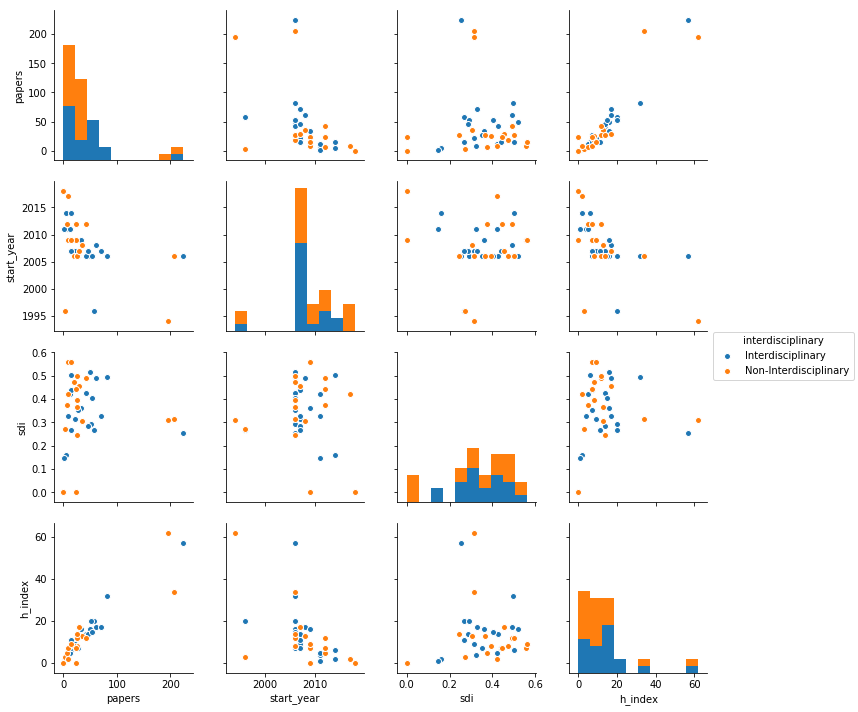

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(data, hue='interdisciplinary')

A few things that immediately pop out are the three outliers, scientists who have authored over 200 papers. The straight line in the start year data around 2005 is something that I've seen before, and is probably an artifact.  I think that in 2005 Web of Science began indexing many more journals. It looks like there's a linear relationship between papers and the h-index, which is not surprising. And I can't see any clear way to distinguish interdisciplinary and non-interdisciplinary scholars. 

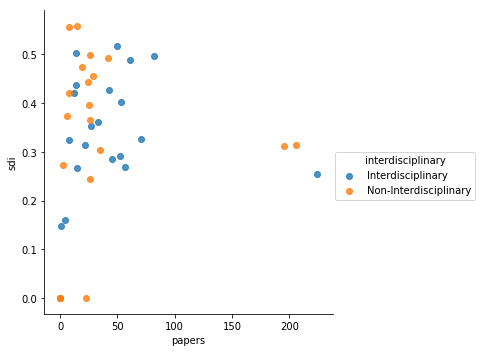

In [185]:
sns.lmplot( x="papers", y="sdi", data=data, fit_reg=False, hue='interdisciplinary', legend=True)

Looking at the plot of papers vs SDI in closer detail, we see pretty much the same thing, or lack of pattern. 

/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


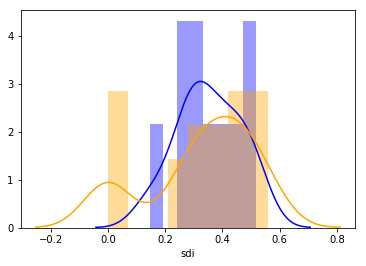

In [218]:
p1 = sns.distplot(data.sdi[data.interdisciplinary=='Interdisciplinary'], color='blue', bins=8, label='Interdisciplinary')
p2 = sns.distplot(data.sdi[data.interdisciplinary=='Non-Interdisciplinary'], color='orange', bins=8, label='Non-Interdisciplinary')

Plotting the histograms of SDI scores together lets us see that there might not be as much difference between the two groups in our sample as we thought. It may be time to pause and re-evl